## Precompute spectrograms for input to hawkears model and for quicker training cycles
The aim of this notebook is to develop a method for exporting the dataset  of spectrograms to disk. 

Additionally, it provides a method to get back from a pre-computed spectrogram to the original audio file on disk.

Finally, it saves the 3s audio clips to disk too. 


In [1]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import take_sample
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
import torch
import glob
import matplotlib.pyplot as plt
import hashlib

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load the dataframe from disk

In [2]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


## Set the output paths


In [48]:
train_present_save_path = Path.joinpath(data_path, "processed", "spectrograms", "train", "present")
train_absent_save_path = Path.joinpath(data_path, "processed", "spectrograms", "train", "absent")
valid_present_save_path = Path.joinpath(data_path, "processed", "spectrograms", "valid", "present")
valid_absent_save_path = Path.joinpath(data_path, "processed", "spectrograms", "valid", "absent")

save_paths = [train_present_save_path, train_absent_save_path, valid_present_save_path, valid_absent_save_path]
for path in save_paths:
    path.mkdir(parents=True, exist_ok=True)

Take a sample of the dataframe by recording.


In [34]:
df_train_sample = take_sample(df_train, 0.1, seed=42)

sampled 5442 recordings from the original 54416 


In [35]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
string_to_hash = ''.join(pd.util.hash_pandas_object(df_train_sample, index=False).astype(str))

# Use hashlib to create a hash of the entire DataFrame
hash_value = hashlib.sha256(string_to_hash.encode()).hexdigest()
print(hash_value)

f65bcbf7f1362a9907a26e50d23956d8411d5570a2cd8ec57a921703c7e9e280


In [36]:
assert hash_value == "f65bcbf7f1362a9907a26e50d23956d8411d5570a2cd8ec57a921703c7e9e280", "The dataframe has changed"

# Turn the DataFrame into an AudioFileDataset
This uses the process in build.py to generate clip start and finish times for each of the downloaded recordings, and pairs the clips with their corresponding labels. No splitting of the audio is done here. A different train and validation set are generated each time the function is called. 

8 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    24865
None     5779
1SPM     5589
Name: count, dtype: int64
total recordings = 36233

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                   131.0          1153.0
1SPT                   280.0          4303.0
NaN                    109.0           598.0
total target clips =  520
total absence clips =  6054
total available human labelled target tags = 435
undefined 29659

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    4583
1SPM    1284
None     707
Name: count, dtype: int64
total recordings = 6574

Tags generated from each tagging method:
             target_presence  target_absence
task_method    

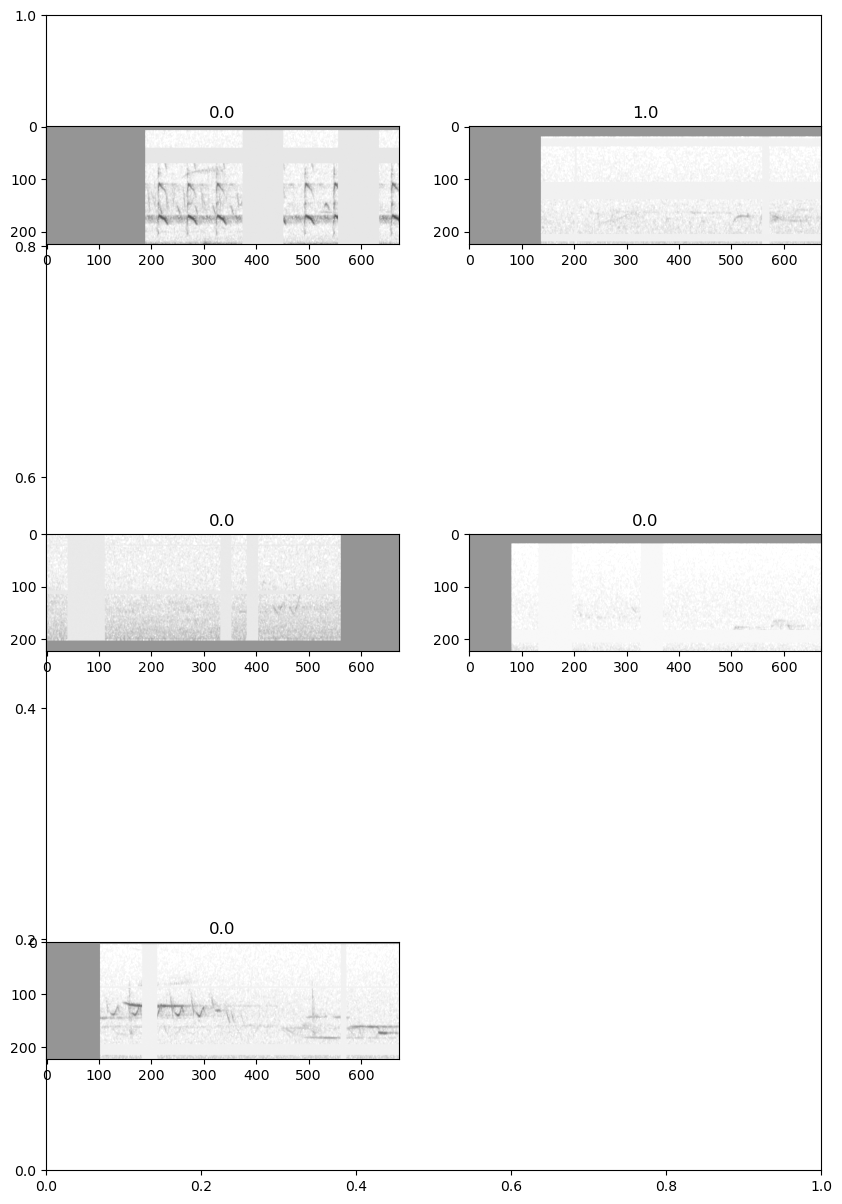

In [37]:
target_species = "OSFL"
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train_sample, target_species = target_species, download_n = 0, one_class=False)

# Downsample the absent class
We have access to much more data from the absent class than from the presence class, so downsampling allows the model to see more of the data from the presence class. 

In [39]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present, random_state=42)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([436., 436.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([84., 84.])))

# Make datasets of presence and absence clips. 

In [40]:
train_present_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==1.0]
train_absent_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==0.0]
valid_present_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==1.0]
valid_absent_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==0.0]

datasets = [train_present_ds, train_absent_ds, valid_present_ds, valid_absent_ds]

# Delete existing spectrograms if there are any

In [10]:
input(f"Warning, this will delete the files contained in {save_paths}.")
for ds, save_path in zip(datasets, save_paths):
    for file in save_path.iterdir():
        file.unlink()

# save the datasets as tensor spectrograms. 

In [11]:
def precompute_spectrograms(datasets, save_paths):
    for ds, save_path in zip(datasets, save_paths):
        for clip_index in ds.index:
            clip_path, start, end = clip_index
            filename = clip_path.parts[-1] + "-" + str(start) + "-" + str(end) + "-.pkl"
            audio = Audio.from_file(clip_path, offset=start, duration=end-start)
            spec = Spectrogram.from_audio(audio)
            im = spec.to_image(invert=False, return_type='torch')
            torch.save(im, save_path.joinpath(filename))
precompute_spectrograms(datasets, save_paths)

# Define a function to get from the spectrogram back to the original audio file

In [49]:

def spec_to_audio(spec_filename, audio_path):
    '''
    Utility function to get from a precomputed spectrogram back to the same segment of the audio file.

    The filename of the spectrogram is used.
    Filename format:
    recording-<recording_id>.<file_extension>-<offset>-<end>-.pkl
    Example filename: 
    recording-4429.mp3-12.0-15.0-.pkl

    Args:
        spec_filename (str): filename of the spectrogram
        audio_path (str): path to the audio files
    Returns:
        path (str): path to the source audio file
        offset (float): offset in seconds from beginning of the recording
        duration (str): duration of the clip in seconds.
'''
    _, rec_file, offset, end, _ = spec_filename.split("-")
    duration = float(end) - float(offset)
    path = Path(f"{audio_path}/recording-{rec_file}")
    return path, float(offset), duration

In [515]:
counter = 0

COUNT 60


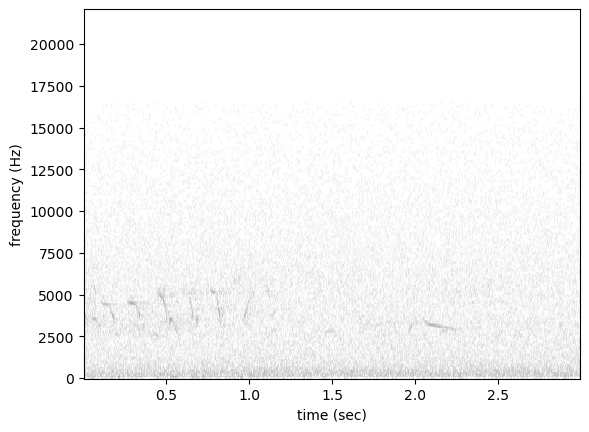

<Audio(samples=(132300,), sample_rate=44100)>

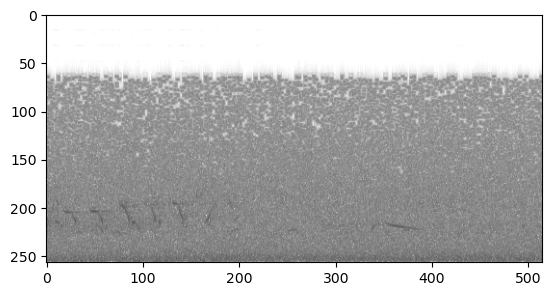

In [576]:
spec_path = train_present_save_path
spectrogram_file_paths = glob.glob(str(spec_path) + "/*")
spectrogram_file_names = [Path(p).parts[-1] for p in spectrogram_file_paths]

audio_path = train_present_ds.index[0][0].parent

print("COUNT " + str(counter))
counter+=1

path, start, duration = spec_to_audio(spec_filename=spectrogram_file_names[counter], audio_path=audio_path)

audio = Audio.from_file(path, offset=start, duration=duration)
spec = Spectrogram.from_audio(audio)
spec.plot() 
tensor = torch.load(spectrogram_file_paths[counter])
show_tensor(tensor)
audio


### In this test set of 388 samples, I listened to all of the presence clips and looked at the spectrograms, and confirmed the presence of 312 olive sided flycatcher calls out of 388. 

This means that 20% of the recall difference could be due to mis-labelled data. 

(PosixPath('../../data/raw/recordings/OSFL/recording-100730.flac'), 151.5, 3.0)
This spectrogram had some cool features in it. 

# test the amplitude plot function


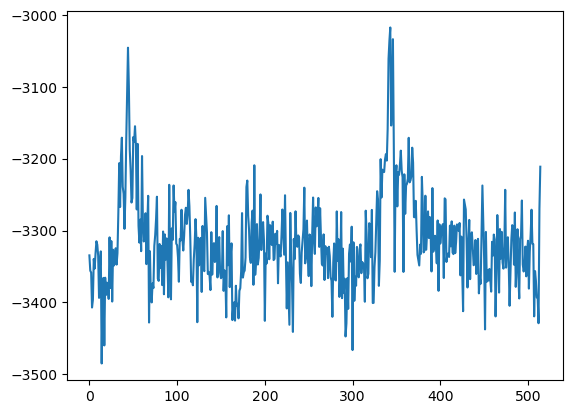

In [16]:
plt.plot(spec.amplitude(freq_range=(2500, 5500)))

In [17]:
# Generate an audio clips dataset
train_present_save_path = Path.joinpath(data_path, "processed", "audio_clips", "train", "present")
train_absent_save_path = Path.joinpath(data_path, "processed", "audio_clips", "train", "absent")
valid_present_save_path = Path.joinpath(data_path, "processed", "audio_clips", "valid", "present")
valid_absent_save_path = Path.joinpath(data_path, "processed", "audio_clips", "valid", "absent")

save_paths = [train_present_save_path, train_absent_save_path, valid_present_save_path, valid_absent_save_path]
for path in save_paths:
    path.mkdir(parents=True, exist_ok=True)

# Delete existing audio files if there are any

In [18]:
input(f"Warning, this will delete the files contained in {save_paths}.")
for ds, save_path in zip(datasets, save_paths):
    for file in save_path.iterdir():
        file.unlink()

# Save Some audio files

In [19]:
def save_audio_clips(datasets, save_paths):
    file_idx = 0


    for ds, save_path in zip(datasets, save_paths):
        for clip_index in ds.index:
            clip_path, start, end = clip_index
            file_idx +=1
            str_file_index = str(file_idx).zfill(5)
            filename = str_file_index + "-" + str(start) + "-" + str(end) + "-" + clip_path.parts[-1]
            audio = Audio.from_file(clip_path, offset=start, duration=end-start)
            audio.save(save_path.joinpath(filename))
            print(filename)
save_audio_clips(datasets, save_paths)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00001-30.0-33.0-recording-4429.mp3
00002-139.5-142.5-recording-4429.mp3
00003-123.0-126.0-recording-4819.mp3
00004-51.0-54.0-recording-4928.flac
00005-73.5-76.5-recording-4928.flac
00006-123.0-126.0-recording-4928.flac
00007-150.0-153.0-recording-48527.mp3
00008-9.0-12.0-recording-48543.mp3
00009-61.5-64.5-recording-48543.mp3
00010-121.5-124.5-recording-48543.mp3
00011-45.0-48.0-recording-50049.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00012-46.5-49.5-recording-50049.flac
00013-109.5-112.5-recording-50049.flac
00014-151.5-154.5-recording-50049.flac
00015-40.5-43.5-recording-70890.mp3
00016-108.0-111.0-recording-97976.mp3
00017-1.5-4.5-recording-99092.mp3
00018-61.5-64.5-recording-99092.mp3
00019-121.5-124.5-recording-99092.mp3
00020-138.0-141.0-recording-100132.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00021-48.0-51.0-recording-100192.mp3
00022-64.5-67.5-recording-100192.mp3
00023-118.5-121.5-recording-100192.mp3
00024-120.0-123.0-recording-100192.mp3
00025-31.5-34.5-recording-100329.mp3
00026-124.5-127.5-recording-100329.mp3
00027-45.0-48.0-recording-103813.mp3
00028-66.0-69.0-recording-103813.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00029-120.0-123.0-recording-103813.mp3
00030-0.0-3.0-recording-104316.mp3
00031-61.5-64.5-recording-104316.mp3
00032-123.0-126.0-recording-104316.mp3
00033-7.5-10.5-recording-141104.mp3
00034-9.0-12.0-recording-141104.mp3
00035-31.5-34.5-recording-144812.mp3
00036-94.5-97.5-recording-144812.mp3
00037-141.0-144.0-recording-169644.flac
00038-142.5-145.5-recording-169644.flac
00039-6.0-9.0-recording-186920.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00040-273.0-276.0-recording-207114.mp3
00041-141.0-144.0-recording-218519.flac
00042-142.5-145.5-recording-218519.flac
00043-0.0-3.0-recording-255544.flac
00044-1.5-4.5-recording-255544.flac
00045-6.0-9.0-recording-255544.flac
00046-10.5-13.5-recording-255544.flac
00047-18.0-21.0-recording-255544.flac
00048-22.5-25.5-recording-255544.flac
00049-25.5-28.5-recording-255544.flac
00050-30.0-33.0-recording-255544.flac
00051-33.0-36.0-recording-255544.flac
00052-34.5-37.5-recording-255544.flac
00053-37.5-40.5-recording-255544.flac
00054-42.0-45.0-recording-255544.flac
00055-46.5-49.5-recording-255544.flac
00056-54.0-57.0-recording-255544.flac
00057-57.0-60.0-recording-255544.flac
00058-58.5-61.5-recording-255544.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00059-54.0-57.0-recording-255580.mp3
00060-1.5-4.5-recording-255582.mp3
00061-9.0-12.0-recording-255582.mp3
00062-12.0-15.0-recording-255582.mp3
00063-13.5-16.5-recording-255582.mp3
00064-19.5-22.5-recording-255582.mp3
00065-24.0-27.0-recording-255582.mp3
00066-28.5-31.5-recording-255582.mp3
00067-40.5-43.5-recording-255582.mp3
00068-43.5-46.5-recording-255582.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00069-48.0-51.0-recording-255582.mp3
00070-54.0-57.0-recording-255582.mp3
00071-0.0-3.0-recording-256055.mp3
00072-4.5-7.5-recording-256055.mp3
00073-9.0-12.0-recording-256055.mp3
00074-13.5-16.5-recording-256055.mp3
00075-16.5-19.5-recording-256055.mp3
00076-21.0-24.0-recording-256055.mp3
00077-25.5-28.5-recording-256055.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00078-30.0-33.0-recording-256055.mp3
00079-34.5-37.5-recording-256055.mp3
00080-39.0-42.0-recording-256055.mp3
00081-43.5-46.5-recording-256055.mp3
00082-46.5-49.5-recording-256055.mp3
00083-51.0-54.0-recording-256055.mp3
00084-57.0-60.0-recording-256055.mp3
00085-58.5-61.5-recording-256055.mp3
00086-130.5-133.5-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00087-15.0-18.0-recording-280076.mp3
00088-0.0-3.0-recording-291496.mp3
00089-295.5-298.5-recording-291508.mp3
00090-15.0-18.0-recording-291584.mp3
00091-7.5-10.5-recording-291648.mp3
00092-9.0-12.0-recording-291648.mp3
00093-0.0-3.0-recording-291663.mp3
00094-1.5-4.5-recording-291663.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00095-18.0-21.0-recording-291793.mp3
00096-19.5-22.5-recording-291793.mp3
00097-7.5-10.5-recording-291859.mp3
00098-69.0-72.0-recording-292029.mp3
00099-36.0-39.0-recording-292039.mp3
00100-51.0-54.0-recording-292071.mp3
00101-52.5-55.5-recording-292071.mp3
00102-6.0-9.0-recording-292165.mp3
00103-0.0-3.0-recording-292199.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00104-72.0-75.0-recording-292199.mp3
00105-0.0-3.0-recording-292215.mp3
00106-33.0-36.0-recording-292215.mp3
00107-6.0-9.0-recording-292249.mp3
00108-30.0-33.0-recording-292249.mp3
00109-1.5-4.5-recording-292300.mp3
00110-3.0-6.0-recording-292300.mp3
00111-78.0-81.0-recording-292300.mp3
00112-15.0-18.0-recording-292418.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00113-54.0-57.0-recording-292467.mp3
00114-48.0-51.0-recording-292471.mp3
00115-49.5-52.5-recording-292471.mp3
00116-19.5-22.5-recording-292507.mp3
00117-21.0-24.0-recording-292507.mp3
00118-0.0-3.0-recording-292513.mp3
00119-1.5-4.5-recording-292559.mp3
00120-3.0-6.0-recording-292559.mp3
00121-13.5-16.5-recording-292559.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00122-3.0-6.0-recording-292616.mp3
00123-18.0-21.0-recording-292616.mp3
00124-0.0-3.0-recording-292638.mp3
00125-52.5-55.5-recording-292740.mp3
00126-13.5-16.5-recording-292753.mp3
00127-15.0-18.0-recording-292753.mp3
00128-28.5-31.5-recording-292753.mp3
00129-30.0-33.0-recording-292753.mp3
00130-84.0-87.0-recording-292753.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00131-132.0-135.0-recording-292755.mp3
00132-133.5-136.5-recording-292755.mp3
00133-10.5-13.5-recording-292812.mp3
00134-12.0-15.0-recording-292812.mp3
00135-1.5-4.5-recording-292835.mp3
00136-97.5-100.5-recording-292836.mp3
00137-99.0-102.0-recording-292836.mp3
00138-6.0-9.0-recording-292861.mp3
00139-7.5-10.5-recording-292861.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00140-18.0-21.0-recording-292868.mp3
00141-4.5-7.5-recording-292876.mp3
00142-7.5-10.5-recording-292896.mp3
00143-21.0-24.0-recording-292954.mp3
00144-22.5-25.5-recording-292954.mp3
00145-69.0-72.0-recording-293060.mp3
00146-163.5-166.5-recording-293060.mp3
00147-19.5-22.5-recording-293159.mp3
00148-18.0-21.0-recording-293184.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00149-19.5-22.5-recording-293184.mp3
00150-159.0-162.0-recording-293303.mp3
00151-57.0-60.0-recording-293422.mp3
00152-72.0-75.0-recording-293422.mp3
00153-21.0-24.0-recording-293497.mp3
00154-15.0-18.0-recording-293518.mp3
00155-16.5-19.5-recording-293518.mp3
00156-0.0-3.0-recording-293662.mp3
00157-30.0-33.0-recording-293662.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00158-16.5-19.5-recording-293678.mp3
00159-6.0-9.0-recording-294104.mp3
00160-36.0-39.0-recording-294105.mp3
00161-37.5-40.5-recording-294105.mp3
00162-7.5-10.5-recording-294316.mp3
00163-39.0-42.0-recording-294316.mp3
00164-13.5-16.5-recording-294323.mp3
00165-10.5-13.5-recording-294351.mp3
00166-1.5-4.5-recording-294419.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00167-3.0-6.0-recording-294419.mp3
00168-1.5-4.5-recording-294423.mp3
00169-3.0-6.0-recording-294423.mp3
00170-10.5-13.5-recording-294435.mp3
00171-12.0-15.0-recording-294435.mp3
00172-37.5-40.5-recording-294467.mp3
00173-16.5-19.5-recording-294489.mp3
00174-31.5-34.5-recording-294582.mp3
00175-1.5-4.5-recording-294584.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00176-13.5-16.5-recording-294584.mp3
00177-24.0-27.0-recording-294584.mp3
00178-25.5-28.5-recording-294584.mp3
00179-30.0-33.0-recording-294589.mp3
00180-31.5-34.5-recording-294589.mp3
00181-7.5-10.5-recording-294744.mp3
00182-37.5-40.5-recording-294747.mp3
00183-4.5-7.5-recording-294805.mp3
00184-6.0-9.0-recording-294805.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00185-3.0-6.0-recording-294858.mp3
00186-1.5-4.5-recording-295017.mp3
00187-19.5-22.5-recording-295126.mp3
00188-39.0-42.0-recording-295267.mp3
00189-16.5-19.5-recording-295299.mp3
00190-18.0-21.0-recording-295299.mp3
00191-1.5-4.5-recording-295446.mp3
00192-12.0-15.0-recording-295480.mp3
00193-7.5-10.5-recording-295703.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00194-9.0-12.0-recording-295703.mp3
00195-6.0-9.0-recording-295746.mp3
00196-7.5-10.5-recording-295746.mp3
00197-27.0-30.0-recording-295857.mp3
00198-12.0-15.0-recording-295861.mp3
00199-1.5-4.5-recording-296282.mp3
00200-3.0-6.0-recording-296282.mp3
00201-9.0-12.0-recording-296282.mp3
00202-15.0-18.0-recording-296285.mp3
00203-16.5-19.5-recording-296285.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00204-6.0-9.0-recording-296305.mp3
00205-7.5-10.5-recording-296305.mp3
00206-3.0-6.0-recording-296355.mp3
00207-33.0-36.0-recording-296785.mp3
00208-34.5-37.5-recording-296785.mp3
00209-12.0-15.0-recording-297080.mp3
00210-13.5-16.5-recording-297080.mp3
00211-40.5-43.5-recording-297258.mp3
00212-42.0-45.0-recording-297258.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00213-135.0-138.0-recording-298091.mp3
00214-10.5-13.5-recording-299105.mp3
00215-43.5-46.5-recording-304887.flac
00216-70.5-73.5-recording-304930.flac
00217-0.0-3.0-recording-305010.flac
00218-4.5-7.5-recording-305104.mp3
00219-84.0-87.0-recording-312412.mp3
00220-85.5-88.5-recording-312412.mp3
00221-132.0-135.0-recording-315866.mp3
00222-3.0-6.0-recording-315894.mp3
00223-120.0-123.0-recording-330530.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00224-6.0-9.0-recording-357693.mp3
00225-7.5-10.5-recording-357693.mp3
00226-1.5-4.5-recording-382209.flac
00227-37.5-40.5-recording-389388.flac
00228-6.0-9.0-recording-389640.flac
00229-64.5-67.5-recording-391227.flac
00230-54.0-57.0-recording-413782.flac
00231-112.5-115.5-recording-416982.flac
00232-114.0-117.0-recording-416982.flac
00233-220.5-223.5-recording-481327.flac
00234-222.0-225.0-recording-481327.flac
00235-7.5-10.5-recording-481762.flac
00236-9.0-12.0-recording-481762.flac
00237-79.5-82.5-recording-482013.flac
00238-0.0-3.0-recording-529629.flac
00239-0.0-3.0-recording-529645.flac
00240-1.5-4.5-recording-529645.flac
00241-64.5-67.5-recording-538298.flac
00242-259.5-262.5-recording-538298.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00243-3.0-6.0-recording-538340.flac
00244-33.0-36.0-recording-538531.flac
00245-18.0-21.0-recording-538573.flac
00246-19.5-22.5-recording-538573.flac
00247-13.5-16.5-recording-538914.flac
00248-4.5-7.5-recording-541587.flac
00249-10.5-13.5-recording-541612.flac
00250-12.0-15.0-recording-541612.flac
00251-10.5-13.5-recording-541632.flac
00252-3.0-6.0-recording-552529.flac
00253-4.5-7.5-recording-552529.flac
00254-43.5-46.5-recording-552559.flac
00255-3.0-6.0-recording-552568.flac
00256-10.5-13.5-recording-552571.flac
00257-91.5-94.5-recording-552592.flac
00258-9.0-12.0-recording-552594.flac
00259-12.0-15.0-recording-552659.flac
00260-13.5-16.5-recording-552659.flac
00261-1.5-4.5-recording-552669.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00262-0.0-3.0-recording-552758.flac
00263-1.5-4.5-recording-552758.flac
00264-1.5-4.5-recording-552879.flac
00265-3.0-6.0-recording-552879.flac
00266-1.5-4.5-recording-552931.flac
00267-22.5-25.5-recording-552947.flac
00268-27.0-30.0-recording-553125.flac
00269-28.5-31.5-recording-553125.flac
00270-0.0-3.0-recording-553187.flac
00271-10.5-13.5-recording-553193.flac
00272-0.0-3.0-recording-553266.flac
00273-3.0-6.0-recording-553392.flac
00274-4.5-7.5-recording-553392.flac
00275-148.5-151.5-recording-553491.flac
00276-177.0-180.0-recording-553501.flac
00277-114.0-117.0-recording-553561.flac
00278-115.5-118.5-recording-553561.flac
00279-0.0-3.0-recording-553685.flac
00280-1.5-4.5-recording-553685.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00281-37.5-40.5-recording-553725.flac
00282-22.5-25.5-recording-553807.flac
00283-24.0-27.0-recording-553807.flac
00284-21.0-24.0-recording-553839.flac
00285-0.0-3.0-recording-553874.flac
00286-1.5-4.5-recording-553874.flac
00287-94.5-97.5-recording-553874.flac
00288-96.0-99.0-recording-553874.flac
00289-0.0-3.0-recording-553891.flac
00290-1.5-4.5-recording-553893.flac
00291-3.0-6.0-recording-553893.flac
00292-24.0-27.0-recording-554028.flac
00293-1.5-4.5-recording-554034.flac
00294-6.0-9.0-recording-554254.flac
00295-4.5-7.5-recording-554256.flac
00296-15.0-18.0-recording-554276.flac
00297-6.0-9.0-recording-554674.flac
00298-7.5-10.5-recording-554891.flac
00299-46.5-49.5-recording-554913.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00300-48.0-51.0-recording-554913.flac
00301-37.5-40.5-recording-554969.flac
00302-10.5-13.5-recording-555071.flac
00303-12.0-15.0-recording-555071.flac
00304-1.5-4.5-recording-555130.flac
00305-15.0-18.0-recording-555130.flac
00306-0.0-3.0-recording-555132.flac
00307-10.5-13.5-recording-555132.flac
00308-3.0-6.0-recording-555152.flac
00309-57.0-60.0-recording-555213.flac
00310-3.0-6.0-recording-555273.flac
00311-4.5-7.5-recording-555273.flac
00312-0.0-3.0-recording-555377.flac
00313-1.5-4.5-recording-555377.flac
00314-21.0-24.0-recording-555399.flac
00315-22.5-25.5-recording-555642.flac
00316-1.5-4.5-recording-555647.flac
00317-3.0-6.0-recording-555647.flac
00318-33.0-36.0-recording-555692.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00319-34.5-37.5-recording-555692.flac
00320-4.5-7.5-recording-555717.flac
00321-6.0-9.0-recording-555765.flac
00322-28.5-31.5-recording-555791.flac
00323-19.5-22.5-recording-555969.flac
00324-21.0-24.0-recording-555969.flac
00325-7.5-10.5-recording-555982.flac
00326-40.5-43.5-recording-556082.flac
00327-1.5-4.5-recording-556095.flac
00328-27.0-30.0-recording-556097.flac
00329-0.0-3.0-recording-556107.flac
00330-1.5-4.5-recording-556107.flac
00331-55.5-58.5-recording-556125.flac
00332-22.5-25.5-recording-556126.flac
00333-24.0-27.0-recording-556126.flac
00334-22.5-25.5-recording-556183.flac
00335-13.5-16.5-recording-556437.flac
00336-0.0-3.0-recording-556468.flac
00337-9.0-12.0-recording-556647.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00338-10.5-13.5-recording-556647.flac
00339-31.5-34.5-recording-556647.flac
00340-0.0-3.0-recording-556648.flac
00341-1.5-4.5-recording-556648.flac
00342-6.0-9.0-recording-556664.flac
00343-4.5-7.5-recording-556675.flac
00344-6.0-9.0-recording-556675.flac
00345-10.5-13.5-recording-556693.flac
00346-42.0-45.0-recording-556748.flac
00347-28.5-31.5-recording-556818.flac
00348-28.5-31.5-recording-556821.flac
00349-12.0-15.0-recording-557171.flac
00350-112.5-115.5-recording-557823.flac
00351-1.5-4.5-recording-566132.flac
00352-57.0-60.0-recording-566133.flac
00353-46.5-49.5-recording-566214.flac
00354-48.0-51.0-recording-566214.flac
00355-6.0-9.0-recording-566238.flac
00356-43.5-46.5-recording-566238.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00357-45.0-48.0-recording-566238.flac
00358-45.0-48.0-recording-566654.flac
00359-46.5-49.5-recording-566654.flac
00360-103.5-106.5-recording-577634.flac
00361-0.0-3.0-recording-577769.flac
00362-1.5-4.5-recording-577769.flac
00363-1.5-4.5-recording-577771.flac
00364-19.5-22.5-recording-613714.flac
00365-57.0-60.0-recording-615123.flac
00366-58.5-61.5-recording-615123.flac
00367-13.5-16.5-recording-615542.flac
00368-10.5-13.5-recording-622392.flac
00369-12.0-15.0-recording-622392.flac
00370-82.5-85.5-recording-622392.flac
00371-114.0-117.0-recording-622397.flac
00372-1.5-4.5-recording-622478.flac
00373-0.0-3.0-recording-813319.flac
00374-42.0-45.0-recording-815817.flac
00375-42.0-45.0-recording-815818.flac
00376-43.5-46.5-recording-815818.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00377-40.5-43.5-recording-815882.flac
00378-28.5-31.5-recording-816287.flac
00379-36.0-39.0-recording-816289.flac
00380-52.5-55.5-recording-816783.flac
00381-28.5-31.5-recording-816784.flac
00382-4.5-7.5-recording-816785.flac
00383-31.5-34.5-recording-826151.flac
00384-18.0-21.0-recording-826231.flac
00385-9.0-12.0-recording-826278.flac
00386-7.5-10.5-recording-826279.flac
00387-3.0-6.0-recording-826374.flac
00388-15.0-18.0-recording-826374.flac
00389-156.0-159.0-recording-553501.flac
00390-21.0-24.0-recording-292740.mp3
00391-91.5-94.5-recording-97976.mp3
00392-19.5-22.5-recording-207114.mp3
00393-15.0-18.0-recording-555791.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00394-208.5-211.5-recording-291508.mp3
00395-7.5-10.5-recording-615123.flac
00396-88.5-91.5-recording-315866.mp3
00397-108.0-111.0-recording-553491.flac
00398-156.0-159.0-recording-481327.flac
00399-0.0-3.0-recording-100329.mp3
00400-9.0-12.0-recording-389388.flac
00401-33.0-36.0-recording-416982.flac
00402-40.5-43.5-recording-103813.mp3
00403-21.0-24.0-recording-553725.flac
00404-121.5-124.5-recording-315866.mp3
00405-45.0-48.0-recording-292467.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00406-13.5-16.5-recording-556097.flac
00407-3.0-6.0-recording-553725.flac
00408-99.0-102.0-recording-557823.flac
00409-63.0-66.0-recording-577634.flac
00410-6.0-9.0-recording-144812.mp3
00411-64.5-67.5-recording-291508.mp3
00412-97.5-100.5-recording-277670.mp3
00413-202.5-205.5-recording-291508.mp3
00414-27.0-30.0-recording-413782.flac
00415-141.0-144.0-recording-48527.mp3
00416-4.5-7.5-recording-280076.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00417-79.5-82.5-recording-277670.mp3
00418-51.0-54.0-recording-207114.mp3
00419-13.5-16.5-recording-100132.mp3
00420-33.0-36.0-recording-304887.flac
00421-43.5-46.5-recording-577634.flac
00422-3.0-6.0-recording-613714.flac
00423-3.0-6.0-recording-553839.flac
00424-31.5-34.5-recording-555213.flac
00425-259.5-262.5-recording-291508.mp3
00426-87.0-90.0-recording-218519.flac
00427-21.0-24.0-recording-4819.mp3
00428-4.5-7.5-recording-292029.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00429-145.5-148.5-recording-48527.mp3
00430-13.5-16.5-recording-293422.mp3
00431-97.5-100.5-recording-315866.mp3
00432-127.5-130.5-recording-481327.flac
00433-13.5-16.5-recording-315866.mp3
00434-106.5-109.5-recording-553561.flac
00435-49.5-52.5-recording-577634.flac
00436-97.5-100.5-recording-100132.mp3
00437-34.5-37.5-recording-100192.mp3
00438-7.5-10.5-recording-304887.flac
00439-43.5-46.5-recording-538298.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00440-33.0-36.0-recording-292740.mp3
00441-39.0-42.0-recording-292471.mp3
00442-6.0-9.0-recording-97976.mp3
00443-217.5-220.5-recording-291508.mp3
00444-18.0-21.0-recording-555642.flac
00445-85.5-88.5-recording-97976.mp3
00446-21.0-24.0-recording-293422.mp3
00447-4.5-7.5-recording-538298.flac
00448-13.5-16.5-recording-538298.flac
00449-4.5-7.5-recording-556082.flac
00450-0.0-3.0-recording-292954.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00451-88.5-91.5-recording-553561.flac
00452-1.5-4.5-recording-305104.mp3
00453-39.0-42.0-recording-815817.flac
00454-99.0-102.0-recording-48527.mp3
00455-6.0-9.0-recording-4819.mp3
00456-10.5-13.5-recording-553491.flac
00457-66.0-69.0-recording-48527.mp3
00458-289.5-292.5-recording-291508.mp3
00459-25.5-28.5-recording-552592.flac
00460-67.5-70.5-recording-292755.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00461-43.5-46.5-recording-553561.flac
00462-102.0-105.0-recording-553561.flac
00463-30.0-33.0-recording-413782.flac
00464-30.0-33.0-recording-207114.mp3
00465-117.0-120.0-recording-298091.mp3
00466-54.0-57.0-recording-330530.flac
00467-217.5-220.5-recording-207114.mp3
00468-0.0-3.0-recording-556097.flac
00469-25.5-28.5-recording-255580.mp3
00470-90.0-93.0-recording-553491.flac
00471-24.0-27.0-recording-553501.flac
00472-4.5-7.5-recording-315866.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00473-16.5-19.5-recording-556183.flac
00474-81.0-84.0-recording-557823.flac
00475-33.0-36.0-recording-297258.mp3
00476-109.5-112.5-recording-169644.flac
00477-19.5-22.5-recording-552559.flac
00478-10.5-13.5-recording-4819.mp3
00479-1.5-4.5-recording-296305.mp3
00480-16.5-19.5-recording-553501.flac
00481-33.0-36.0-recording-97976.mp3
00482-27.0-30.0-recording-294747.mp3
00483-39.0-42.0-recording-169644.flac
00484-37.5-40.5-recording-312412.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00485-18.0-21.0-recording-552559.flac
00486-25.5-28.5-recording-556082.flac
00487-46.5-49.5-recording-553491.flac
00488-75.0-78.0-recording-298091.mp3
00489-60.0-63.0-recording-481327.flac
00490-36.0-39.0-recording-292755.mp3
00491-93.0-96.0-recording-577634.flac
00492-7.5-10.5-recording-555692.flac
00493-141.0-144.0-recording-481327.flac
00494-0.0-3.0-recording-294467.mp3
00495-79.5-82.5-recording-557823.flac
00496-18.0-21.0-recording-292740.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00497-85.5-88.5-recording-277670.mp3
00498-145.5-148.5-recording-291508.mp3
00499-30.0-33.0-recording-416982.flac
00500-160.5-163.5-recording-207114.mp3
00501-22.5-25.5-recording-100329.mp3
00502-15.0-18.0-recording-416982.flac
00503-10.5-13.5-recording-293303.mp3
00504-178.5-181.5-recording-207114.mp3
00505-13.5-16.5-recording-554028.flac
00506-55.5-58.5-recording-312412.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00507-4.5-7.5-recording-293422.mp3
00508-148.5-151.5-recording-207114.mp3
00509-13.5-16.5-recording-555642.flac
00510-24.0-27.0-recording-554969.flac
00511-3.0-6.0-recording-555765.flac
00512-205.5-208.5-recording-207114.mp3
00513-12.0-15.0-recording-330530.flac
00514-112.5-115.5-recording-293303.mp3
00515-28.5-31.5-recording-293303.mp3
00516-75.0-78.0-recording-4819.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00517-28.5-31.5-recording-291508.mp3
00518-43.5-46.5-recording-816783.flac
00519-36.0-39.0-recording-315866.mp3
00520-13.5-16.5-recording-389388.flac
00521-127.5-130.5-recording-207114.mp3
00522-16.5-19.5-recording-553807.flac
00523-97.5-100.5-recording-553561.flac
00524-115.5-118.5-recording-330530.flac
00525-40.5-43.5-recording-552592.flac
00526-4.5-7.5-recording-97976.mp3
00527-43.5-46.5-recording-292740.mp3
00528-16.5-19.5-recording-293060.mp3
00529-16.5-19.5-recording-50049.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00530-3.0-6.0-recording-292029.mp3
00531-13.5-16.5-recording-553501.flac
00532-55.5-58.5-recording-330530.flac
00533-54.0-57.0-recording-553491.flac
00534-15.0-18.0-recording-552559.flac
00535-30.0-33.0-recording-816783.flac
00536-34.5-37.5-recording-556748.flac
00537-4.5-7.5-recording-481327.flac
00538-90.0-93.0-recording-4819.mp3
00539-15.0-18.0-recording-295299.mp3
00540-27.0-30.0-recording-294582.mp3
00541-0.0-3.0-recording-343221.mp3
00542-12.0-15.0-recording-280076.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00543-0.0-3.0-recording-295746.mp3
00544-34.5-37.5-recording-816783.flac
00545-178.5-181.5-recording-481327.flac
00546-69.0-72.0-recording-48527.mp3
00547-4.5-7.5-recording-299105.mp3
00548-66.0-69.0-recording-292836.mp3
00549-25.5-28.5-recording-100192.mp3
00550-0.0-3.0-recording-553193.flac
00551-72.0-75.0-recording-207114.mp3
00552-18.0-21.0-recording-4429.mp3
00553-4.5-7.5-recording-296785.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00554-75.0-78.0-recording-100132.mp3
00555-34.5-37.5-recording-557823.flac
00556-48.0-51.0-recording-255580.mp3
00557-1.5-4.5-recording-481762.flac
00558-10.5-13.5-recording-292418.mp3
00559-30.0-33.0-recording-312412.mp3
00560-85.5-88.5-recording-315866.mp3
00561-16.5-19.5-recording-48527.mp3
00562-31.5-34.5-recording-538298.flac
00563-3.0-6.0-recording-297258.mp3
00564-12.0-15.0-recording-291508.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00565-12.0-15.0-recording-4429.mp3
00566-111.0-114.0-recording-481327.flac
00567-43.5-46.5-recording-100132.mp3
00568-12.0-15.0-recording-292868.mp3
00569-45.0-48.0-recording-481327.flac
00570-36.0-39.0-recording-481327.flac
00571-108.0-111.0-recording-557823.flac
00572-30.0-33.0-recording-815817.flac
00573-28.5-31.5-recording-298091.mp3
00574-37.5-40.5-recording-291508.mp3
00575-28.5-31.5-recording-292029.mp3
00576-43.5-46.5-recording-292836.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00577-0.0-3.0-recording-4928.flac
00578-9.0-12.0-recording-556748.flac
00579-0.0-3.0-recording-292165.mp3
00580-24.0-27.0-recording-816287.flac
00581-118.5-121.5-recording-100132.mp3
00582-63.0-66.0-recording-416982.flac
00583-55.5-58.5-recording-622397.flac
00584-30.0-33.0-recording-615123.flac
00585-1.5-4.5-recording-556818.flac
00586-214.5-217.5-recording-207114.mp3
00587-42.0-45.0-recording-103813.mp3
00588-12.0-15.0-recording-554276.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00589-190.5-193.5-recording-291508.mp3
00590-3.0-6.0-recording-304930.flac
00591-36.0-39.0-recording-48527.mp3
00592-30.0-33.0-recording-294467.mp3
00593-19.5-22.5-recording-556125.flac
00594-0.0-3.0-recording-553501.flac
00595-10.5-13.5-recording-100132.mp3
00596-6.0-9.0-recording-555969.flac
00597-3.0-6.0-recording-291648.mp3
00598-10.5-13.5-recording-295126.mp3
00599-148.5-151.5-recording-291508.mp3
00600-6.0-9.0-recording-218519.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00601-9.0-12.0-recording-292954.mp3
00602-25.5-28.5-recording-416982.flac
00603-13.5-16.5-recording-538531.flac
00604-60.0-63.0-recording-292029.mp3
00605-7.5-10.5-recording-554276.flac
00606-58.5-61.5-recording-292755.mp3
00607-108.0-111.0-recording-298091.mp3
00608-6.0-9.0-recording-294582.mp3
00609-43.5-46.5-recording-312412.mp3
00610-88.5-91.5-recording-298091.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00611-12.0-15.0-recording-293497.mp3
00612-231.0-234.0-recording-207114.mp3
00613-37.5-40.5-recording-556748.flac
00614-7.5-10.5-recording-292029.mp3
00615-39.0-42.0-recording-622397.flac
00616-75.0-78.0-recording-293303.mp3
00617-12.0-15.0-recording-622397.flac
00618-16.5-19.5-recording-293422.mp3
00619-36.0-39.0-recording-169644.flac
00620-73.5-76.5-recording-552592.flac
00621-3.0-6.0-recording-538298.flac
00622-28.5-31.5-recording-100329.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00623-63.0-66.0-recording-553491.flac
00624-96.0-99.0-recording-293303.mp3
00625-13.5-16.5-recording-554913.flac
00626-7.5-10.5-recording-552947.flac
00627-12.0-15.0-recording-556097.flac
00628-4.5-7.5-recording-141104.mp3
00629-36.0-39.0-recording-70890.mp3
00630-7.5-10.5-recording-816287.flac
00631-3.0-6.0-recording-816783.flac
00632-160.5-163.5-recording-481327.flac
00633-3.0-6.0-recording-48527.mp3
00634-73.5-76.5-recording-557823.flac
00635-0.0-3.0-recording-556126.flac
00636-1.5-4.5-recording-169644.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00637-30.0-33.0-recording-70890.mp3
00638-79.5-82.5-recording-552592.flac
00639-87.0-90.0-recording-552592.flac
00640-1.5-4.5-recording-294351.mp3
00641-43.5-46.5-recording-481327.flac
00642-15.0-18.0-recording-4819.mp3
00643-3.0-6.0-recording-293060.mp3
00644-220.5-223.5-recording-291508.mp3
00645-76.5-79.5-recording-100132.mp3
00646-18.0-21.0-recording-292071.mp3
00647-0.0-3.0-recording-555765.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00648-16.5-19.5-recording-552947.flac
00649-111.0-114.0-recording-277670.mp3
00650-115.5-118.5-recording-315866.mp3
00651-9.0-12.0-recording-566133.flac
00652-12.0-15.0-recording-552592.flac
00653-25.5-28.5-recording-615123.flac
00654-162.0-165.0-recording-481327.flac
00655-55.5-58.5-recording-615123.flac
00656-73.5-76.5-recording-312412.mp3
00657-18.0-21.0-recording-566654.flac
00658-72.0-75.0-recording-552592.flac
00659-21.0-24.0-recording-554028.flac
00660-28.5-31.5-recording-304887.flac
00661-22.5-25.5-recording-50049.flac
00662-18.0-21.0-recording-556082.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00663-9.0-12.0-recording-622392.flac
00664-43.5-46.5-recording-277670.mp3
00665-70.5-73.5-recording-330530.flac
00666-63.0-66.0-recording-4819.mp3
00667-4.5-7.5-recording-50049.flac
00668-37.5-40.5-recording-292029.mp3
00669-1.5-4.5-recording-292755.mp3
00670-39.0-42.0-recording-292467.mp3
00671-73.5-76.5-recording-553501.flac
00672-55.5-58.5-recording-293303.mp3
00673-76.5-79.5-recording-4819.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00674-0.0-3.0-recording-207114.mp3
00675-49.5-52.5-recording-553491.flac
00676-82.5-85.5-recording-292755.mp3
00677-54.0-57.0-recording-169644.flac
00678-4.5-7.5-recording-556693.flac
00679-6.0-9.0-recording-541612.flac
00680-31.5-34.5-recording-218519.flac
00681-22.5-25.5-recording-556082.flac
00682-46.5-49.5-recording-555213.flac
00683-82.5-85.5-recording-553561.flac
00684-18.0-21.0-recording-556821.flac
00685-3.0-6.0-recording-280076.mp3
00686-30.0-33.0-recording-577634.flac
00687-43.5-46.5-recording-97976.mp3
00688-15.0-18.0-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00689-18.0-21.0-recording-293060.mp3
00690-96.0-99.0-recording-481327.flac
00691-27.0-30.0-recording-48527.mp3
00692-127.5-130.5-recording-553491.flac
00693-90.0-93.0-recording-416982.flac
00694-15.0-18.0-recording-100192.mp3
00695-61.5-64.5-recording-218519.flac
00696-25.5-28.5-recording-294105.mp3
00697-52.5-55.5-recording-553561.flac
00698-9.0-12.0-recording-552592.flac
00699-18.0-21.0-recording-315866.mp3
00700-37.5-40.5-recording-552559.flac
00701-4.5-7.5-recording-553501.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00702-94.5-97.5-recording-291508.mp3
00703-13.5-16.5-recording-293184.mp3
00704-25.5-28.5-recording-482013.flac
00705-31.5-34.5-recording-577634.flac
00706-19.5-22.5-recording-100192.mp3
00707-28.5-31.5-recording-294582.mp3
00708-103.5-106.5-recording-330530.flac
00709-157.5-160.5-recording-291508.mp3
00710-19.5-22.5-recording-295857.mp3
00711-4.5-7.5-recording-615542.flac
00712-130.5-133.5-recording-481327.flac
00713-18.0-21.0-recording-826151.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00714-195.0-198.0-recording-207114.mp3
00715-31.5-34.5-recording-555692.flac
00716-0.0-3.0-recording-304887.flac
00717-222.0-225.0-recording-207114.mp3
00718-25.5-28.5-recording-293060.mp3
00719-3.0-6.0-recording-554674.flac
00720-1.5-4.5-recording-538573.flac
00721-12.0-15.0-recording-826151.flac
00722-4.5-7.5-recording-816289.flac
00723-16.5-19.5-recording-816287.flac
00724-27.0-30.0-recording-556082.flac
00725-21.0-24.0-recording-816783.flac
00726-16.5-19.5-recording-304887.flac
00727-4.5-7.5-recording-292039.mp3
00728-1.5-4.5-recording-50049.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00729-4.5-7.5-recording-482013.flac
00730-151.5-154.5-recording-553501.flac
00731-3.0-6.0-recording-622392.flac
00732-76.5-79.5-recording-291508.mp3
00733-28.5-31.5-recording-297258.mp3
00734-22.5-25.5-recording-615123.flac
00735-54.0-57.0-recording-577634.flac
00736-78.0-81.0-recording-100132.mp3
00737-16.5-19.5-recording-556097.flac
00738-13.5-16.5-recording-555692.flac
00739-34.5-37.5-recording-100132.mp3
00740-19.5-22.5-recording-556082.flac
00741-13.5-16.5-recording-298091.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00742-81.0-84.0-recording-312412.mp3
00743-69.0-72.0-recording-552592.flac
00744-99.0-102.0-recording-169644.flac
00745-4.5-7.5-recording-295861.mp3
00746-18.0-21.0-recording-552947.flac
00747-49.5-52.5-recording-292029.mp3
00748-144.0-147.0-recording-291508.mp3
00749-13.5-16.5-recording-4928.flac
00750-70.5-73.5-recording-312412.mp3
00751-120.0-123.0-recording-293303.mp3
00752-15.0-18.0-recording-291508.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00753-75.0-78.0-recording-292755.mp3
00754-21.0-24.0-recording-553125.flac
00755-4.5-7.5-recording-622397.flac
00756-115.5-118.5-recording-292755.mp3
00757-6.0-9.0-recording-280076.mp3
00758-40.5-43.5-recording-481327.flac
00759-48.0-51.0-recording-4819.mp3
00760-10.5-13.5-recording-556097.flac
00761-196.5-199.5-recording-291508.mp3
00762-54.0-57.0-recording-553561.flac
00763-210.0-213.0-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00764-126.0-129.0-recording-291508.mp3
00765-1.5-4.5-recording-48543.mp3
00766-61.5-64.5-recording-416982.flac
00767-4.5-7.5-recording-292418.mp3
00768-1.5-4.5-recording-297258.mp3
00769-109.5-112.5-recording-315866.mp3
00770-4.5-7.5-recording-556437.flac
00771-99.0-102.0-recording-293303.mp3
00772-34.5-37.5-recording-70890.mp3
00773-1.5-4.5-recording-416982.flac
00774-127.5-130.5-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00775-76.5-79.5-recording-577634.flac
00776-39.0-42.0-recording-207114.mp3
00777-30.0-33.0-recording-4429.mp3
00778-139.5-142.5-recording-4429.mp3
00779-123.0-126.0-recording-4819.mp3
00780-51.0-54.0-recording-4928.flac
00781-73.5-76.5-recording-4928.flac
00782-123.0-126.0-recording-4928.flac
00783-150.0-153.0-recording-48527.mp3
00784-9.0-12.0-recording-48543.mp3
00785-61.5-64.5-recording-48543.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00786-121.5-124.5-recording-48543.mp3
00787-45.0-48.0-recording-50049.flac
00788-46.5-49.5-recording-50049.flac
00789-109.5-112.5-recording-50049.flac
00790-151.5-154.5-recording-50049.flac
00791-40.5-43.5-recording-70890.mp3
00792-108.0-111.0-recording-97976.mp3
00793-1.5-4.5-recording-99092.mp3
00794-61.5-64.5-recording-99092.mp3
00795-121.5-124.5-recording-99092.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00796-138.0-141.0-recording-100132.mp3
00797-48.0-51.0-recording-100192.mp3
00798-64.5-67.5-recording-100192.mp3
00799-118.5-121.5-recording-100192.mp3
00800-120.0-123.0-recording-100192.mp3
00801-31.5-34.5-recording-100329.mp3
00802-124.5-127.5-recording-100329.mp3
00803-45.0-48.0-recording-103813.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00804-66.0-69.0-recording-103813.mp3
00805-120.0-123.0-recording-103813.mp3
00806-0.0-3.0-recording-104316.mp3
00807-61.5-64.5-recording-104316.mp3
00808-123.0-126.0-recording-104316.mp3
00809-7.5-10.5-recording-141104.mp3
00810-9.0-12.0-recording-141104.mp3
00811-31.5-34.5-recording-144812.mp3
00812-94.5-97.5-recording-144812.mp3
00813-141.0-144.0-recording-169644.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00814-142.5-145.5-recording-169644.flac
00815-6.0-9.0-recording-186920.mp3
00816-273.0-276.0-recording-207114.mp3
00817-141.0-144.0-recording-218519.flac
00818-142.5-145.5-recording-218519.flac
00819-0.0-3.0-recording-255544.flac
00820-1.5-4.5-recording-255544.flac
00821-6.0-9.0-recording-255544.flac
00822-10.5-13.5-recording-255544.flac
00823-18.0-21.0-recording-255544.flac
00824-22.5-25.5-recording-255544.flac
00825-25.5-28.5-recording-255544.flac
00826-30.0-33.0-recording-255544.flac
00827-33.0-36.0-recording-255544.flac
00828-34.5-37.5-recording-255544.flac
00829-37.5-40.5-recording-255544.flac
00830-42.0-45.0-recording-255544.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00831-46.5-49.5-recording-255544.flac
00832-54.0-57.0-recording-255544.flac
00833-57.0-60.0-recording-255544.flac
00834-58.5-61.5-recording-255544.flac
00835-54.0-57.0-recording-255580.mp3
00836-1.5-4.5-recording-255582.mp3
00837-9.0-12.0-recording-255582.mp3
00838-12.0-15.0-recording-255582.mp3
00839-13.5-16.5-recording-255582.mp3
00840-19.5-22.5-recording-255582.mp3
00841-24.0-27.0-recording-255582.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00842-28.5-31.5-recording-255582.mp3
00843-40.5-43.5-recording-255582.mp3
00844-43.5-46.5-recording-255582.mp3
00845-48.0-51.0-recording-255582.mp3
00846-54.0-57.0-recording-255582.mp3
00847-0.0-3.0-recording-256055.mp3
00848-4.5-7.5-recording-256055.mp3
00849-9.0-12.0-recording-256055.mp3
00850-13.5-16.5-recording-256055.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00851-16.5-19.5-recording-256055.mp3
00852-21.0-24.0-recording-256055.mp3
00853-25.5-28.5-recording-256055.mp3
00854-30.0-33.0-recording-256055.mp3
00855-34.5-37.5-recording-256055.mp3
00856-39.0-42.0-recording-256055.mp3
00857-43.5-46.5-recording-256055.mp3
00858-46.5-49.5-recording-256055.mp3
00859-51.0-54.0-recording-256055.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00860-57.0-60.0-recording-256055.mp3
00861-58.5-61.5-recording-256055.mp3
00862-130.5-133.5-recording-277670.mp3
00863-15.0-18.0-recording-280076.mp3
00864-0.0-3.0-recording-291496.mp3
00865-295.5-298.5-recording-291508.mp3
00866-15.0-18.0-recording-291584.mp3
00867-7.5-10.5-recording-291648.mp3
00868-9.0-12.0-recording-291648.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00869-0.0-3.0-recording-291663.mp3
00870-1.5-4.5-recording-291663.mp3
00871-18.0-21.0-recording-291793.mp3
00872-19.5-22.5-recording-291793.mp3
00873-7.5-10.5-recording-291859.mp3
00874-69.0-72.0-recording-292029.mp3
00875-36.0-39.0-recording-292039.mp3
00876-51.0-54.0-recording-292071.mp3
00877-52.5-55.5-recording-292071.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00878-6.0-9.0-recording-292165.mp3
00879-0.0-3.0-recording-292199.mp3
00880-72.0-75.0-recording-292199.mp3
00881-0.0-3.0-recording-292215.mp3
00882-33.0-36.0-recording-292215.mp3
00883-6.0-9.0-recording-292249.mp3
00884-30.0-33.0-recording-292249.mp3
00885-1.5-4.5-recording-292300.mp3
00886-3.0-6.0-recording-292300.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00887-78.0-81.0-recording-292300.mp3
00888-15.0-18.0-recording-292418.mp3
00889-54.0-57.0-recording-292467.mp3
00890-48.0-51.0-recording-292471.mp3
00891-49.5-52.5-recording-292471.mp3
00892-19.5-22.5-recording-292507.mp3
00893-21.0-24.0-recording-292507.mp3
00894-0.0-3.0-recording-292513.mp3
00895-1.5-4.5-recording-292559.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00896-3.0-6.0-recording-292559.mp3
00897-13.5-16.5-recording-292559.mp3
00898-3.0-6.0-recording-292616.mp3
00899-18.0-21.0-recording-292616.mp3
00900-0.0-3.0-recording-292638.mp3
00901-52.5-55.5-recording-292740.mp3
00902-13.5-16.5-recording-292753.mp3
00903-15.0-18.0-recording-292753.mp3
00904-28.5-31.5-recording-292753.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00905-30.0-33.0-recording-292753.mp3
00906-84.0-87.0-recording-292753.mp3
00907-132.0-135.0-recording-292755.mp3
00908-133.5-136.5-recording-292755.mp3
00909-10.5-13.5-recording-292812.mp3
00910-12.0-15.0-recording-292812.mp3
00911-1.5-4.5-recording-292835.mp3
00912-97.5-100.5-recording-292836.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00913-99.0-102.0-recording-292836.mp3
00914-6.0-9.0-recording-292861.mp3
00915-7.5-10.5-recording-292861.mp3
00916-18.0-21.0-recording-292868.mp3
00917-4.5-7.5-recording-292876.mp3
00918-7.5-10.5-recording-292896.mp3
00919-21.0-24.0-recording-292954.mp3
00920-22.5-25.5-recording-292954.mp3
00921-69.0-72.0-recording-293060.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00922-163.5-166.5-recording-293060.mp3
00923-19.5-22.5-recording-293159.mp3
00924-18.0-21.0-recording-293184.mp3
00925-19.5-22.5-recording-293184.mp3
00926-159.0-162.0-recording-293303.mp3
00927-57.0-60.0-recording-293422.mp3
00928-72.0-75.0-recording-293422.mp3
00929-21.0-24.0-recording-293497.mp3
00930-15.0-18.0-recording-293518.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00931-16.5-19.5-recording-293518.mp3
00932-0.0-3.0-recording-293662.mp3
00933-30.0-33.0-recording-293662.mp3
00934-16.5-19.5-recording-293678.mp3
00935-6.0-9.0-recording-294104.mp3
00936-36.0-39.0-recording-294105.mp3
00937-37.5-40.5-recording-294105.mp3
00938-7.5-10.5-recording-294316.mp3
00939-39.0-42.0-recording-294316.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00940-13.5-16.5-recording-294323.mp3
00941-10.5-13.5-recording-294351.mp3
00942-1.5-4.5-recording-294419.mp3
00943-3.0-6.0-recording-294419.mp3
00944-1.5-4.5-recording-294423.mp3
00945-3.0-6.0-recording-294423.mp3
00946-10.5-13.5-recording-294435.mp3
00947-12.0-15.0-recording-294435.mp3
00948-37.5-40.5-recording-294467.mp3
00949-16.5-19.5-recording-294489.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00950-31.5-34.5-recording-294582.mp3
00951-1.5-4.5-recording-294584.mp3
00952-13.5-16.5-recording-294584.mp3
00953-24.0-27.0-recording-294584.mp3
00954-25.5-28.5-recording-294584.mp3
00955-30.0-33.0-recording-294589.mp3
00956-31.5-34.5-recording-294589.mp3
00957-7.5-10.5-recording-294744.mp3
00958-37.5-40.5-recording-294747.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00959-4.5-7.5-recording-294805.mp3
00960-6.0-9.0-recording-294805.mp3
00961-3.0-6.0-recording-294858.mp3
00962-1.5-4.5-recording-295017.mp3
00963-19.5-22.5-recording-295126.mp3
00964-39.0-42.0-recording-295267.mp3
00965-16.5-19.5-recording-295299.mp3
00966-18.0-21.0-recording-295299.mp3
00967-1.5-4.5-recording-295446.mp3
00968-12.0-15.0-recording-295480.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00969-7.5-10.5-recording-295703.mp3
00970-9.0-12.0-recording-295703.mp3
00971-6.0-9.0-recording-295746.mp3
00972-7.5-10.5-recording-295746.mp3
00973-27.0-30.0-recording-295857.mp3
00974-12.0-15.0-recording-295861.mp3
00975-1.5-4.5-recording-296282.mp3
00976-3.0-6.0-recording-296282.mp3
00977-9.0-12.0-recording-296282.mp3
00978-15.0-18.0-recording-296285.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00979-16.5-19.5-recording-296285.mp3
00980-6.0-9.0-recording-296305.mp3
00981-7.5-10.5-recording-296305.mp3
00982-3.0-6.0-recording-296355.mp3
00983-33.0-36.0-recording-296785.mp3
00984-34.5-37.5-recording-296785.mp3
00985-12.0-15.0-recording-297080.mp3
00986-13.5-16.5-recording-297080.mp3
00987-40.5-43.5-recording-297258.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00988-42.0-45.0-recording-297258.mp3
00989-135.0-138.0-recording-298091.mp3
00990-10.5-13.5-recording-299105.mp3
00991-43.5-46.5-recording-304887.flac
00992-70.5-73.5-recording-304930.flac
00993-0.0-3.0-recording-305010.flac
00994-4.5-7.5-recording-305104.mp3
00995-84.0-87.0-recording-312412.mp3
00996-85.5-88.5-recording-312412.mp3
00997-132.0-135.0-recording-315866.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

00998-3.0-6.0-recording-315894.mp3
00999-120.0-123.0-recording-330530.flac
01000-6.0-9.0-recording-357693.mp3
01001-7.5-10.5-recording-357693.mp3
01002-1.5-4.5-recording-382209.flac
01003-37.5-40.5-recording-389388.flac
01004-6.0-9.0-recording-389640.flac
01005-64.5-67.5-recording-391227.flac
01006-54.0-57.0-recording-413782.flac
01007-112.5-115.5-recording-416982.flac
01008-114.0-117.0-recording-416982.flac
01009-220.5-223.5-recording-481327.flac
01010-222.0-225.0-recording-481327.flac
01011-7.5-10.5-recording-481762.flac
01012-9.0-12.0-recording-481762.flac
01013-79.5-82.5-recording-482013.flac
01014-0.0-3.0-recording-529629.flac
01015-0.0-3.0-recording-529645.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01016-1.5-4.5-recording-529645.flac
01017-64.5-67.5-recording-538298.flac
01018-259.5-262.5-recording-538298.flac
01019-3.0-6.0-recording-538340.flac
01020-33.0-36.0-recording-538531.flac
01021-18.0-21.0-recording-538573.flac
01022-19.5-22.5-recording-538573.flac
01023-13.5-16.5-recording-538914.flac
01024-4.5-7.5-recording-541587.flac
01025-10.5-13.5-recording-541612.flac
01026-12.0-15.0-recording-541612.flac
01027-10.5-13.5-recording-541632.flac
01028-3.0-6.0-recording-552529.flac
01029-4.5-7.5-recording-552529.flac
01030-43.5-46.5-recording-552559.flac
01031-3.0-6.0-recording-552568.flac
01032-10.5-13.5-recording-552571.flac
01033-91.5-94.5-recording-552592.flac
01034-9.0-12.0-recording-552594.flac
01035-12.0-15.0-recording-552659.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01036-13.5-16.5-recording-552659.flac
01037-1.5-4.5-recording-552669.flac
01038-0.0-3.0-recording-552758.flac
01039-1.5-4.5-recording-552758.flac
01040-1.5-4.5-recording-552879.flac
01041-3.0-6.0-recording-552879.flac
01042-1.5-4.5-recording-552931.flac
01043-22.5-25.5-recording-552947.flac
01044-27.0-30.0-recording-553125.flac
01045-28.5-31.5-recording-553125.flac
01046-0.0-3.0-recording-553187.flac
01047-10.5-13.5-recording-553193.flac
01048-0.0-3.0-recording-553266.flac
01049-3.0-6.0-recording-553392.flac
01050-4.5-7.5-recording-553392.flac
01051-148.5-151.5-recording-553491.flac
01052-177.0-180.0-recording-553501.flac
01053-114.0-117.0-recording-553561.flac
01054-115.5-118.5-recording-553561.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01055-0.0-3.0-recording-553685.flac
01056-1.5-4.5-recording-553685.flac
01057-37.5-40.5-recording-553725.flac
01058-22.5-25.5-recording-553807.flac
01059-24.0-27.0-recording-553807.flac
01060-21.0-24.0-recording-553839.flac
01061-0.0-3.0-recording-553874.flac
01062-1.5-4.5-recording-553874.flac
01063-94.5-97.5-recording-553874.flac
01064-96.0-99.0-recording-553874.flac
01065-0.0-3.0-recording-553891.flac
01066-1.5-4.5-recording-553893.flac
01067-3.0-6.0-recording-553893.flac
01068-24.0-27.0-recording-554028.flac
01069-1.5-4.5-recording-554034.flac
01070-6.0-9.0-recording-554254.flac
01071-4.5-7.5-recording-554256.flac
01072-15.0-18.0-recording-554276.flac
01073-6.0-9.0-recording-554674.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01074-7.5-10.5-recording-554891.flac
01075-46.5-49.5-recording-554913.flac
01076-48.0-51.0-recording-554913.flac
01077-37.5-40.5-recording-554969.flac
01078-10.5-13.5-recording-555071.flac
01079-12.0-15.0-recording-555071.flac
01080-1.5-4.5-recording-555130.flac
01081-15.0-18.0-recording-555130.flac
01082-0.0-3.0-recording-555132.flac
01083-10.5-13.5-recording-555132.flac
01084-3.0-6.0-recording-555152.flac
01085-57.0-60.0-recording-555213.flac
01086-3.0-6.0-recording-555273.flac
01087-4.5-7.5-recording-555273.flac
01088-0.0-3.0-recording-555377.flac
01089-1.5-4.5-recording-555377.flac
01090-21.0-24.0-recording-555399.flac
01091-22.5-25.5-recording-555642.flac
01092-1.5-4.5-recording-555647.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01093-3.0-6.0-recording-555647.flac
01094-33.0-36.0-recording-555692.flac
01095-34.5-37.5-recording-555692.flac
01096-4.5-7.5-recording-555717.flac
01097-6.0-9.0-recording-555765.flac
01098-28.5-31.5-recording-555791.flac
01099-19.5-22.5-recording-555969.flac
01100-21.0-24.0-recording-555969.flac
01101-7.5-10.5-recording-555982.flac
01102-40.5-43.5-recording-556082.flac
01103-1.5-4.5-recording-556095.flac
01104-27.0-30.0-recording-556097.flac
01105-0.0-3.0-recording-556107.flac
01106-1.5-4.5-recording-556107.flac
01107-55.5-58.5-recording-556125.flac
01108-22.5-25.5-recording-556126.flac
01109-24.0-27.0-recording-556126.flac
01110-22.5-25.5-recording-556183.flac
01111-13.5-16.5-recording-556437.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01112-0.0-3.0-recording-556468.flac
01113-9.0-12.0-recording-556647.flac
01114-10.5-13.5-recording-556647.flac
01115-31.5-34.5-recording-556647.flac
01116-0.0-3.0-recording-556648.flac
01117-1.5-4.5-recording-556648.flac
01118-6.0-9.0-recording-556664.flac
01119-4.5-7.5-recording-556675.flac
01120-6.0-9.0-recording-556675.flac
01121-10.5-13.5-recording-556693.flac
01122-42.0-45.0-recording-556748.flac
01123-28.5-31.5-recording-556818.flac
01124-28.5-31.5-recording-556821.flac
01125-12.0-15.0-recording-557171.flac
01126-112.5-115.5-recording-557823.flac
01127-1.5-4.5-recording-566132.flac
01128-57.0-60.0-recording-566133.flac
01129-46.5-49.5-recording-566214.flac
01130-48.0-51.0-recording-566214.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01131-6.0-9.0-recording-566238.flac
01132-43.5-46.5-recording-566238.flac
01133-45.0-48.0-recording-566238.flac
01134-45.0-48.0-recording-566654.flac
01135-46.5-49.5-recording-566654.flac
01136-103.5-106.5-recording-577634.flac
01137-0.0-3.0-recording-577769.flac
01138-1.5-4.5-recording-577769.flac
01139-1.5-4.5-recording-577771.flac
01140-19.5-22.5-recording-613714.flac
01141-57.0-60.0-recording-615123.flac
01142-58.5-61.5-recording-615123.flac
01143-13.5-16.5-recording-615542.flac
01144-10.5-13.5-recording-622392.flac
01145-12.0-15.0-recording-622392.flac
01146-82.5-85.5-recording-622392.flac
01147-114.0-117.0-recording-622397.flac
01148-1.5-4.5-recording-622478.flac
01149-0.0-3.0-recording-813319.flac
01150-42.0-45.0-recording-815817.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01151-42.0-45.0-recording-815818.flac
01152-43.5-46.5-recording-815818.flac
01153-40.5-43.5-recording-815882.flac
01154-28.5-31.5-recording-816287.flac
01155-36.0-39.0-recording-816289.flac
01156-52.5-55.5-recording-816783.flac
01157-28.5-31.5-recording-816784.flac
01158-4.5-7.5-recording-816785.flac
01159-31.5-34.5-recording-826151.flac
01160-18.0-21.0-recording-826231.flac
01161-9.0-12.0-recording-826278.flac
01162-7.5-10.5-recording-826279.flac
01163-3.0-6.0-recording-826374.flac
01164-15.0-18.0-recording-826374.flac
01165-156.0-159.0-recording-553501.flac
01166-21.0-24.0-recording-292740.mp3
01167-91.5-94.5-recording-97976.mp3
01168-19.5-22.5-recording-207114.mp3
01169-15.0-18.0-recording-555791.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01170-208.5-211.5-recording-291508.mp3
01171-7.5-10.5-recording-615123.flac
01172-88.5-91.5-recording-315866.mp3
01173-108.0-111.0-recording-553491.flac
01174-156.0-159.0-recording-481327.flac
01175-0.0-3.0-recording-100329.mp3
01176-9.0-12.0-recording-389388.flac
01177-33.0-36.0-recording-416982.flac
01178-40.5-43.5-recording-103813.mp3
01179-21.0-24.0-recording-553725.flac
01180-121.5-124.5-recording-315866.mp3
01181-45.0-48.0-recording-292467.mp3
01182-13.5-16.5-recording-556097.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01183-3.0-6.0-recording-553725.flac
01184-99.0-102.0-recording-557823.flac
01185-63.0-66.0-recording-577634.flac
01186-6.0-9.0-recording-144812.mp3
01187-64.5-67.5-recording-291508.mp3
01188-97.5-100.5-recording-277670.mp3
01189-202.5-205.5-recording-291508.mp3
01190-27.0-30.0-recording-413782.flac
01191-141.0-144.0-recording-48527.mp3
01192-4.5-7.5-recording-280076.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01193-79.5-82.5-recording-277670.mp3
01194-51.0-54.0-recording-207114.mp3
01195-13.5-16.5-recording-100132.mp3
01196-33.0-36.0-recording-304887.flac
01197-43.5-46.5-recording-577634.flac
01198-3.0-6.0-recording-613714.flac
01199-3.0-6.0-recording-553839.flac
01200-31.5-34.5-recording-555213.flac
01201-259.5-262.5-recording-291508.mp3
01202-87.0-90.0-recording-218519.flac
01203-21.0-24.0-recording-4819.mp3
01204-4.5-7.5-recording-292029.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01205-145.5-148.5-recording-48527.mp3
01206-13.5-16.5-recording-293422.mp3
01207-97.5-100.5-recording-315866.mp3
01208-127.5-130.5-recording-481327.flac
01209-13.5-16.5-recording-315866.mp3
01210-106.5-109.5-recording-553561.flac
01211-49.5-52.5-recording-577634.flac
01212-97.5-100.5-recording-100132.mp3
01213-34.5-37.5-recording-100192.mp3
01214-7.5-10.5-recording-304887.flac
01215-43.5-46.5-recording-538298.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01216-33.0-36.0-recording-292740.mp3
01217-39.0-42.0-recording-292471.mp3
01218-6.0-9.0-recording-97976.mp3
01219-217.5-220.5-recording-291508.mp3
01220-18.0-21.0-recording-555642.flac
01221-85.5-88.5-recording-97976.mp3
01222-21.0-24.0-recording-293422.mp3
01223-4.5-7.5-recording-538298.flac
01224-13.5-16.5-recording-538298.flac
01225-4.5-7.5-recording-556082.flac
01226-0.0-3.0-recording-292954.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01227-88.5-91.5-recording-553561.flac
01228-1.5-4.5-recording-305104.mp3
01229-39.0-42.0-recording-815817.flac
01230-99.0-102.0-recording-48527.mp3
01231-6.0-9.0-recording-4819.mp3
01232-10.5-13.5-recording-553491.flac
01233-66.0-69.0-recording-48527.mp3
01234-289.5-292.5-recording-291508.mp3
01235-25.5-28.5-recording-552592.flac
01236-67.5-70.5-recording-292755.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01237-43.5-46.5-recording-553561.flac
01238-102.0-105.0-recording-553561.flac
01239-30.0-33.0-recording-413782.flac
01240-30.0-33.0-recording-207114.mp3
01241-117.0-120.0-recording-298091.mp3
01242-54.0-57.0-recording-330530.flac
01243-217.5-220.5-recording-207114.mp3
01244-0.0-3.0-recording-556097.flac
01245-25.5-28.5-recording-255580.mp3
01246-90.0-93.0-recording-553491.flac
01247-24.0-27.0-recording-553501.flac
01248-4.5-7.5-recording-315866.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01249-16.5-19.5-recording-556183.flac
01250-81.0-84.0-recording-557823.flac
01251-33.0-36.0-recording-297258.mp3
01252-109.5-112.5-recording-169644.flac
01253-19.5-22.5-recording-552559.flac
01254-10.5-13.5-recording-4819.mp3
01255-1.5-4.5-recording-296305.mp3
01256-16.5-19.5-recording-553501.flac
01257-33.0-36.0-recording-97976.mp3
01258-27.0-30.0-recording-294747.mp3
01259-39.0-42.0-recording-169644.flac
01260-37.5-40.5-recording-312412.mp3
01261-18.0-21.0-recording-552559.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01262-25.5-28.5-recording-556082.flac
01263-46.5-49.5-recording-553491.flac
01264-75.0-78.0-recording-298091.mp3
01265-60.0-63.0-recording-481327.flac
01266-36.0-39.0-recording-292755.mp3
01267-93.0-96.0-recording-577634.flac
01268-7.5-10.5-recording-555692.flac
01269-141.0-144.0-recording-481327.flac
01270-0.0-3.0-recording-294467.mp3
01271-79.5-82.5-recording-557823.flac
01272-18.0-21.0-recording-292740.mp3
01273-85.5-88.5-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01274-145.5-148.5-recording-291508.mp3
01275-30.0-33.0-recording-416982.flac
01276-160.5-163.5-recording-207114.mp3
01277-22.5-25.5-recording-100329.mp3
01278-15.0-18.0-recording-416982.flac
01279-10.5-13.5-recording-293303.mp3
01280-178.5-181.5-recording-207114.mp3
01281-13.5-16.5-recording-554028.flac
01282-55.5-58.5-recording-312412.mp3
01283-4.5-7.5-recording-293422.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01284-148.5-151.5-recording-207114.mp3
01285-13.5-16.5-recording-555642.flac
01286-24.0-27.0-recording-554969.flac
01287-3.0-6.0-recording-555765.flac
01288-205.5-208.5-recording-207114.mp3
01289-12.0-15.0-recording-330530.flac
01290-112.5-115.5-recording-293303.mp3
01291-28.5-31.5-recording-293303.mp3
01292-75.0-78.0-recording-4819.mp3
01293-28.5-31.5-recording-291508.mp3
01294-43.5-46.5-recording-816783.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01295-36.0-39.0-recording-315866.mp3
01296-13.5-16.5-recording-389388.flac
01297-127.5-130.5-recording-207114.mp3
01298-16.5-19.5-recording-553807.flac
01299-97.5-100.5-recording-553561.flac
01300-115.5-118.5-recording-330530.flac
01301-40.5-43.5-recording-552592.flac
01302-4.5-7.5-recording-97976.mp3
01303-43.5-46.5-recording-292740.mp3
01304-16.5-19.5-recording-293060.mp3
01305-16.5-19.5-recording-50049.flac
01306-3.0-6.0-recording-292029.mp3
01307-13.5-16.5-recording-553501.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01308-55.5-58.5-recording-330530.flac
01309-54.0-57.0-recording-553491.flac
01310-15.0-18.0-recording-552559.flac
01311-30.0-33.0-recording-816783.flac
01312-34.5-37.5-recording-556748.flac
01313-4.5-7.5-recording-481327.flac
01314-90.0-93.0-recording-4819.mp3
01315-15.0-18.0-recording-295299.mp3
01316-27.0-30.0-recording-294582.mp3
01317-0.0-3.0-recording-343221.mp3
01318-12.0-15.0-recording-280076.mp3
01319-0.0-3.0-recording-295746.mp3
01320-34.5-37.5-recording-816783.flac
01321-178.5-181.5-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01322-69.0-72.0-recording-48527.mp3
01323-4.5-7.5-recording-299105.mp3
01324-66.0-69.0-recording-292836.mp3
01325-25.5-28.5-recording-100192.mp3
01326-0.0-3.0-recording-553193.flac
01327-72.0-75.0-recording-207114.mp3
01328-18.0-21.0-recording-4429.mp3
01329-4.5-7.5-recording-296785.mp3
01330-75.0-78.0-recording-100132.mp3
01331-34.5-37.5-recording-557823.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01332-48.0-51.0-recording-255580.mp3
01333-1.5-4.5-recording-481762.flac
01334-10.5-13.5-recording-292418.mp3
01335-30.0-33.0-recording-312412.mp3
01336-85.5-88.5-recording-315866.mp3
01337-16.5-19.5-recording-48527.mp3
01338-31.5-34.5-recording-538298.flac
01339-3.0-6.0-recording-297258.mp3
01340-12.0-15.0-recording-291508.mp3
01341-12.0-15.0-recording-4429.mp3
01342-111.0-114.0-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01343-43.5-46.5-recording-100132.mp3
01344-12.0-15.0-recording-292868.mp3
01345-45.0-48.0-recording-481327.flac
01346-36.0-39.0-recording-481327.flac
01347-108.0-111.0-recording-557823.flac
01348-30.0-33.0-recording-815817.flac
01349-28.5-31.5-recording-298091.mp3
01350-37.5-40.5-recording-291508.mp3
01351-28.5-31.5-recording-292029.mp3
01352-43.5-46.5-recording-292836.mp3
01353-0.0-3.0-recording-4928.flac
01354-9.0-12.0-recording-556748.flac
01355-0.0-3.0-recording-292165.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01356-24.0-27.0-recording-816287.flac
01357-118.5-121.5-recording-100132.mp3
01358-63.0-66.0-recording-416982.flac
01359-55.5-58.5-recording-622397.flac
01360-30.0-33.0-recording-615123.flac
01361-1.5-4.5-recording-556818.flac
01362-214.5-217.5-recording-207114.mp3
01363-42.0-45.0-recording-103813.mp3
01364-12.0-15.0-recording-554276.flac
01365-190.5-193.5-recording-291508.mp3
01366-3.0-6.0-recording-304930.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01367-36.0-39.0-recording-48527.mp3
01368-30.0-33.0-recording-294467.mp3
01369-19.5-22.5-recording-556125.flac
01370-0.0-3.0-recording-553501.flac
01371-10.5-13.5-recording-100132.mp3
01372-6.0-9.0-recording-555969.flac
01373-3.0-6.0-recording-291648.mp3
01374-10.5-13.5-recording-295126.mp3
01375-148.5-151.5-recording-291508.mp3
01376-6.0-9.0-recording-218519.flac
01377-9.0-12.0-recording-292954.mp3
01378-25.5-28.5-recording-416982.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01379-13.5-16.5-recording-538531.flac
01380-60.0-63.0-recording-292029.mp3
01381-7.5-10.5-recording-554276.flac
01382-58.5-61.5-recording-292755.mp3
01383-108.0-111.0-recording-298091.mp3
01384-6.0-9.0-recording-294582.mp3
01385-43.5-46.5-recording-312412.mp3
01386-88.5-91.5-recording-298091.mp3
01387-12.0-15.0-recording-293497.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01388-231.0-234.0-recording-207114.mp3
01389-37.5-40.5-recording-556748.flac
01390-7.5-10.5-recording-292029.mp3
01391-39.0-42.0-recording-622397.flac
01392-75.0-78.0-recording-293303.mp3
01393-12.0-15.0-recording-622397.flac
01394-16.5-19.5-recording-293422.mp3
01395-36.0-39.0-recording-169644.flac
01396-73.5-76.5-recording-552592.flac
01397-3.0-6.0-recording-538298.flac
01398-28.5-31.5-recording-100329.mp3
01399-63.0-66.0-recording-553491.flac
01400-96.0-99.0-recording-293303.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01401-13.5-16.5-recording-554913.flac
01402-7.5-10.5-recording-552947.flac
01403-12.0-15.0-recording-556097.flac
01404-4.5-7.5-recording-141104.mp3
01405-36.0-39.0-recording-70890.mp3
01406-7.5-10.5-recording-816287.flac
01407-3.0-6.0-recording-816783.flac
01408-160.5-163.5-recording-481327.flac
01409-3.0-6.0-recording-48527.mp3
01410-73.5-76.5-recording-557823.flac
01411-0.0-3.0-recording-556126.flac
01412-1.5-4.5-recording-169644.flac
01413-30.0-33.0-recording-70890.mp3
01414-79.5-82.5-recording-552592.flac
01415-87.0-90.0-recording-552592.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01416-1.5-4.5-recording-294351.mp3
01417-43.5-46.5-recording-481327.flac
01418-15.0-18.0-recording-4819.mp3
01419-3.0-6.0-recording-293060.mp3
01420-220.5-223.5-recording-291508.mp3
01421-76.5-79.5-recording-100132.mp3
01422-18.0-21.0-recording-292071.mp3
01423-0.0-3.0-recording-555765.flac
01424-16.5-19.5-recording-552947.flac
01425-111.0-114.0-recording-277670.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01426-115.5-118.5-recording-315866.mp3
01427-9.0-12.0-recording-566133.flac
01428-12.0-15.0-recording-552592.flac
01429-25.5-28.5-recording-615123.flac
01430-162.0-165.0-recording-481327.flac
01431-55.5-58.5-recording-615123.flac
01432-73.5-76.5-recording-312412.mp3
01433-18.0-21.0-recording-566654.flac
01434-72.0-75.0-recording-552592.flac
01435-21.0-24.0-recording-554028.flac
01436-28.5-31.5-recording-304887.flac
01437-22.5-25.5-recording-50049.flac
01438-18.0-21.0-recording-556082.flac
01439-9.0-12.0-recording-622392.flac
01440-43.5-46.5-recording-277670.mp3
01441-70.5-73.5-recording-330530.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01442-63.0-66.0-recording-4819.mp3
01443-4.5-7.5-recording-50049.flac
01444-37.5-40.5-recording-292029.mp3
01445-1.5-4.5-recording-292755.mp3
01446-39.0-42.0-recording-292467.mp3
01447-73.5-76.5-recording-553501.flac
01448-55.5-58.5-recording-293303.mp3
01449-76.5-79.5-recording-4819.mp3
01450-0.0-3.0-recording-207114.mp3
01451-49.5-52.5-recording-553491.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01452-82.5-85.5-recording-292755.mp3
01453-54.0-57.0-recording-169644.flac
01454-4.5-7.5-recording-556693.flac
01455-6.0-9.0-recording-541612.flac
01456-31.5-34.5-recording-218519.flac
01457-22.5-25.5-recording-556082.flac
01458-46.5-49.5-recording-555213.flac
01459-82.5-85.5-recording-553561.flac
01460-18.0-21.0-recording-556821.flac
01461-3.0-6.0-recording-280076.mp3
01462-30.0-33.0-recording-577634.flac
01463-43.5-46.5-recording-97976.mp3
01464-15.0-18.0-recording-277670.mp3
01465-18.0-21.0-recording-293060.mp3
01466-96.0-99.0-recording-481327.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01467-27.0-30.0-recording-48527.mp3
01468-127.5-130.5-recording-553491.flac
01469-90.0-93.0-recording-416982.flac
01470-15.0-18.0-recording-100192.mp3
01471-61.5-64.5-recording-218519.flac
01472-25.5-28.5-recording-294105.mp3
01473-52.5-55.5-recording-553561.flac
01474-9.0-12.0-recording-552592.flac
01475-18.0-21.0-recording-315866.mp3
01476-37.5-40.5-recording-552559.flac
01477-4.5-7.5-recording-553501.flac
01478-94.5-97.5-recording-291508.mp3
01479-13.5-16.5-recording-293184.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01480-25.5-28.5-recording-482013.flac
01481-31.5-34.5-recording-577634.flac
01482-19.5-22.5-recording-100192.mp3
01483-28.5-31.5-recording-294582.mp3
01484-103.5-106.5-recording-330530.flac
01485-157.5-160.5-recording-291508.mp3
01486-19.5-22.5-recording-295857.mp3
01487-4.5-7.5-recording-615542.flac
01488-130.5-133.5-recording-481327.flac
01489-18.0-21.0-recording-826151.flac
01490-195.0-198.0-recording-207114.mp3
01491-31.5-34.5-recording-555692.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01492-0.0-3.0-recording-304887.flac
01493-222.0-225.0-recording-207114.mp3
01494-25.5-28.5-recording-293060.mp3
01495-3.0-6.0-recording-554674.flac
01496-1.5-4.5-recording-538573.flac
01497-12.0-15.0-recording-826151.flac
01498-4.5-7.5-recording-816289.flac
01499-16.5-19.5-recording-816287.flac
01500-27.0-30.0-recording-556082.flac
01501-21.0-24.0-recording-816783.flac
01502-16.5-19.5-recording-304887.flac
01503-4.5-7.5-recording-292039.mp3
01504-1.5-4.5-recording-50049.flac
01505-4.5-7.5-recording-482013.flac
01506-151.5-154.5-recording-553501.flac
01507-3.0-6.0-recording-622392.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01508-76.5-79.5-recording-291508.mp3
01509-28.5-31.5-recording-297258.mp3
01510-22.5-25.5-recording-615123.flac
01511-54.0-57.0-recording-577634.flac
01512-78.0-81.0-recording-100132.mp3
01513-16.5-19.5-recording-556097.flac
01514-13.5-16.5-recording-555692.flac
01515-34.5-37.5-recording-100132.mp3
01516-19.5-22.5-recording-556082.flac
01517-13.5-16.5-recording-298091.mp3
01518-81.0-84.0-recording-312412.mp3
01519-69.0-72.0-recording-552592.flac
01520-99.0-102.0-recording-169644.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01521-4.5-7.5-recording-295861.mp3
01522-18.0-21.0-recording-552947.flac
01523-49.5-52.5-recording-292029.mp3
01524-144.0-147.0-recording-291508.mp3
01525-13.5-16.5-recording-4928.flac
01526-70.5-73.5-recording-312412.mp3
01527-120.0-123.0-recording-293303.mp3
01528-15.0-18.0-recording-291508.mp3
01529-75.0-78.0-recording-292755.mp3
01530-21.0-24.0-recording-553125.flac
01531-4.5-7.5-recording-622397.flac


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

01532-115.5-118.5-recording-292755.mp3
01533-6.0-9.0-recording-280076.mp3
01534-40.5-43.5-recording-481327.flac
01535-48.0-51.0-recording-4819.mp3
01536-10.5-13.5-recording-556097.flac
01537-196.5-199.5-recording-291508.mp3
01538-54.0-57.0-recording-553561.flac
01539-210.0-213.0-recording-481327.flac
01540-126.0-129.0-recording-291508.mp3
01541-1.5-4.5-recording-48543.mp3
01542-61.5-64.5-recording-416982.flac
01543-4.5-7.5-recording-292418.mp3
01544-1.5-4.5-recording-297258.mp3
01545-109.5-112.5-recording-315866.mp3
01546-4.5-7.5-recording-556437.flac
01547-99.0-102.0-recording-293303.mp3
01548-34.5-37.5-recording-70890.mp3
01549-1.5-4.5-recording-416982.flac
01550-127.5-130.5-recording-277670.mp3
01551-76.5-79.5-recording-577634.flac
01552-39.0-42.0-recording-207114.mp3


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83

In [20]:
save_paths[0]

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/audio_clips/train/present')